In [1]:
%config Completer.use_jedi = False
import numpy as np
import cv2
import random
import os
import imageio

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

In [2]:
directory = r'/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [3]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

In [8]:
from collections import Counter
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_valid_rgb = np.repeat(X_valid, 3, axis=-1)
print(len(X_train_rgb), X_train_rgb.shape)
print(len(X_valid_rgb), X_valid_rgb.shape)

822 (822, 256, 256, 3)
275 (275, 256, 256, 3)


In [10]:
X_train = X_train_rgb
print(len(X_train), X_train.shape)
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*3)  
print(len(X_train), X_train.shape)

822 (822, 256, 256, 3)
822 (822, 196608)


In [11]:
from collections import Counter

print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))
num_samples = len(X_train_rgb)
X_train_sampled = X_train_sampled[:num_samples]
y_train_sampled = y_train_sampled[:num_samples]

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False

model_vgg = Sequential()

model_vgg.add(base_model)

model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(3, activation='softmax'))

model_vgg.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 23,104,323
Trainable params: 8,389,635
Non-trainable params: 14,714,688
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


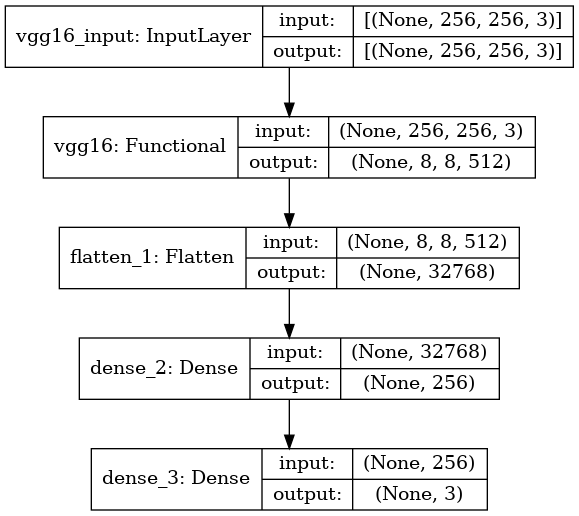

In [13]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model_vgg, show_shapes=True, show_layer_names=True)

In [14]:
history_vgg = model_vgg.fit(X_train_rgb, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid_rgb, y_valid))

Epoch 1/10
103/103 [==============================] - 14s 57ms/step - loss: 0.5863 - accuracy: 0.7786 - val_loss: 0.2613 - val_accuracy: 0.9418
Epoch 2/10
103/103 [==============================] - 4s 37ms/step - loss: 0.1867 - accuracy: 0.9416 - val_loss: 0.2671 - val_accuracy: 0.9091
Epoch 3/10
103/103 [==============================] - 4s 37ms/step - loss: 0.1080 - accuracy: 0.9672 - val_loss: 0.0996 - val_accuracy: 0.9782
Epoch 4/10
103/103 [==============================] - 4s 37ms/step - loss: 0.0582 - accuracy: 0.9927 - val_loss: 0.0707 - val_accuracy: 0.9891
Epoch 5/10
103/103 [==============================] - 4s 37ms/step - loss: 0.0411 - accuracy: 0.9891 - val_loss: 0.0548 - val_accuracy: 0.9964
Epoch 6/10
103/103 [==============================] - 4s 37ms/step - loss: 0.0315 - accuracy: 0.9951 - val_loss: 0.0517 - val_accuracy: 0.9927
Epoch 7/10
103/103 [==============================] - 4s 37ms/step - loss: 0.0322 - accuracy: 0.9951 - val_loss: 0.0426 - val_accuracy: 0.989

In [31]:
model_vgg.save('model_vgg.h5')

In [15]:
y_pred = model_vgg.predict(X_valid_rgb, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

9/9 [==============================] - 6s 355ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.99      1.00      1.00       141
           2       1.00      0.98      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



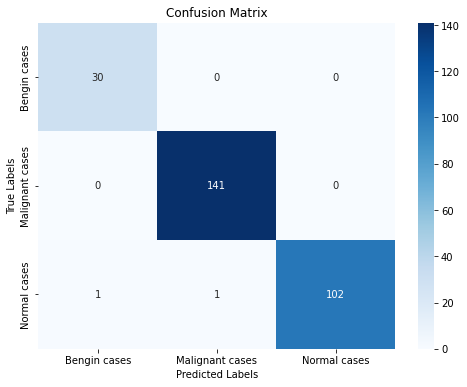

In [17]:

import matplotlib.pyplot as plt


confusion_mat = confusion_matrix(y_valid, y_pred_bool)

class_labels = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

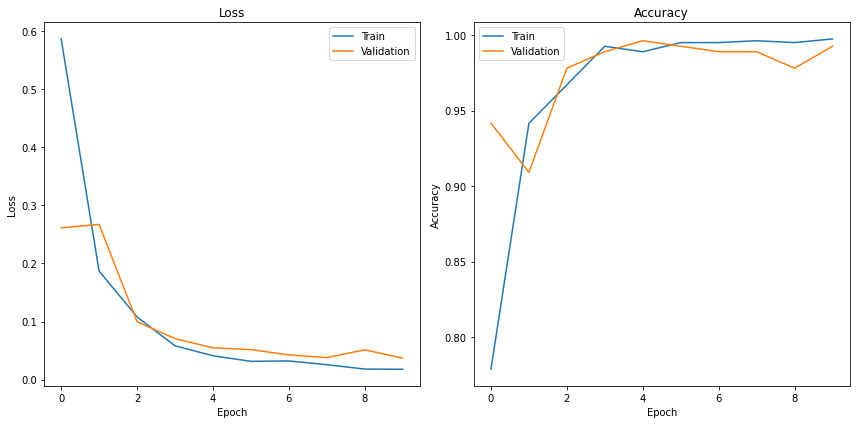

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_vgg.history['loss'], label='Train')
ax1.plot(history_vgg.history['val_loss'], label='Validation')
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(history_vgg.history['accuracy'], label='Train')
ax2.plot(history_vgg.history['val_accuracy'], label='Validation')
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

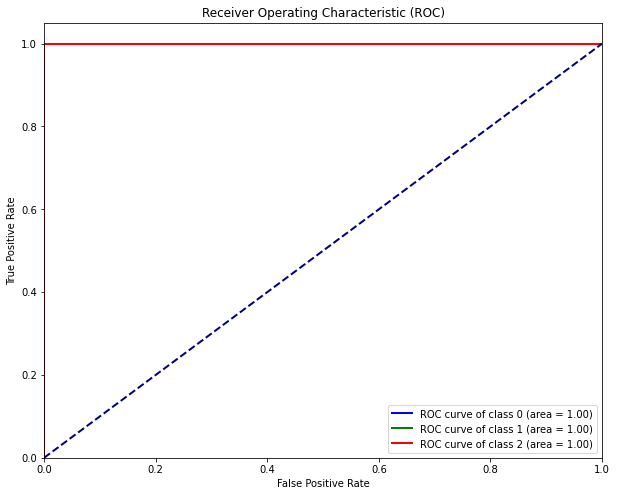

In [28]:
from sklearn.preprocessing import label_binarize

# Convert the labels to one-hot encoded format
y_valid_bin = label_binarize(y_valid, classes=[0, 1, 2])  

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Set num_classes to 3
    fpr[i], tpr[i], _ = roc_curve(y_valid_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red'] 
for i, color in zip(range(3), colors):  # Set num_classes to 3
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
